In [1]:
from collections import Counter
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from utils import *
from topic_utils import *

%matplotlib notebook
pd.options.display.float_format = '{:.2f}'.format
plt.style.use("bmh")

In [2]:
def mean_normalize(df):
    return (df - df.mean()) / df.std()

def min_max_normalize(df):
    return (df - df.min()) / (df.max() - df.min())

In [29]:
counts = ['like_count',
         'quote_count',
         'reply_count',
         'retweet_count',
         ]
plot_stats = ['mean',
             'std',
             ]
stats = ['mean',
         'std',
         'min',
         'max',
        ]

In [3]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')

In [4]:
tweets_df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]

# Exploratory Data Analysis

In [5]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 729129 entries, 1331706590525874184 to 1000259808442961920
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   userid                    729129 non-null  string        
 1   user_display_name         729129 non-null  string        
 2   user_screen_name          729129 non-null  string        
 3   user_reported_location    545336 non-null  string        
 4   user_profile_description  684476 non-null  string        
 5   user_profile_url          448380 non-null  string        
 6   follower_count            729129 non-null  int64         
 7   following_count           729129 non-null  int64         
 8   account_creation_date     729129 non-null  datetime64[ns]
 9   account_language          729129 non-null  string        
 10  tweet_language            603007 non-null  string        
 11  tweet_text                729129 n

In [6]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, GotPdi7ND5U93CiLruCUjAPr0R5af8PkKEZQ9UJHNlE= to umi7TfGCQ73OtREt5v8BMjNBHbg96LnkEmH65RO8Ts=
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   user_display_name         374 non-null    string        
 1   user_screen_name          374 non-null    string        
 2   user_reported_location    162 non-null    string        
 3   user_profile_description  274 non-null    string        
 4   user_profile_url          44 non-null     string        
 5   follower_count            374 non-null    int64         
 6   following_count           374 non-null    int64         
 7   account_creation_date     374 non-null    datetime64[ns]
 8   account_language          374 non-null    string        
 9   file                      374 non-null    string        
 10  campaign                  374 non-null    string        
 11  releas

<IPython.core.display.Javascript object>


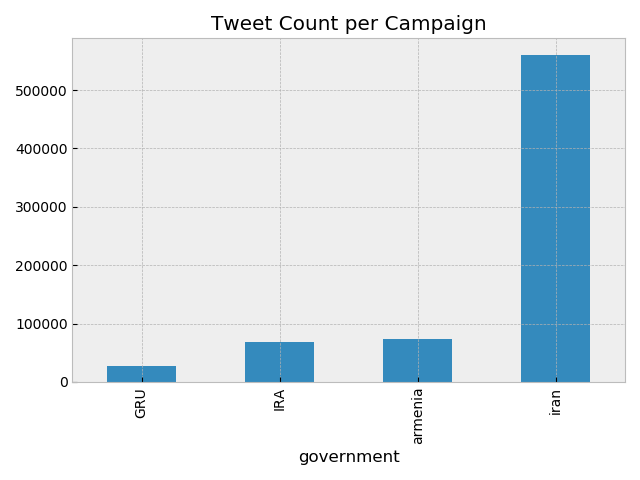

In [7]:
(tweets_df.groupby('government')
  .size()
).plot(kind='bar', title='Tweet Count per Campaign')
plt.tight_layout()

In [9]:
campaign = tweets_df.loc[:][tweets_df['campaign'] =='iran202012']
campaign_users = user_df.loc[:][user_df['campaign'] =='iran202012']

In [10]:
print('Campaign-identified users: {}'.format(len(campaign_users)))

start = (campaign
         .loc[:]['tweet_time']
         .min()
)
end = (campaign
         .loc[:]['tweet_time']
         .max()
)
print('Campaign duration: {}'.format(end - start))

Campaign-identified users: 238
Campaign duration: 4130 days 04:12:00


In [11]:
active_index = campaign_users.index.isin(campaign['userid'])
active_campaign_users = campaign_users[active_index]
inactive_campaign_users = campaign_users[~active_index]

ans = 'Active campaign accounts: {}'.format(len(active_campaign_users))
print(ans)

ans = 'Inactive campaign accounts: {}'.format(len(inactive_campaign_users))
print(ans)

ans = 'Total campaign accounts: {}'.format(len(campaign_users.index))
print(ans)

Active campaign accounts: 209
Inactive campaign accounts: 29
Total campaign accounts: 238


In [12]:
print('Total tweets: {}'.format(len(campaign)))
print('Tweets per user:')
tweets_per_user = (campaign
                .groupby('userid')
                .size()
                .describe()
                .astype('int')
)[['mean','std','min','max']]
print(tweets_per_user)
print('Tweets from max user: {:.2%}'
      .format(tweets_per_user.loc['max'] / len(campaign)))

Total tweets: 560571
Tweets per user:
mean      2682
std      21022
min          1
max     302648
dtype: int64
Tweets from max user: 53.99%


In [13]:
print('Max user:')
max_user = (campaign
           .groupby('userid')
           .size()
           .idxmax()
           )
max_user

Max user:


'213589457'

Interestingly, the top-tweeting user for the Iran campaign is a Spanish-language account, with a user-reported location of Teheran.

In [14]:
campaign_users.loc[max_user]

user_display_name                                                    HispanTV
user_screen_name                                                     Hispantv
user_reported_location                                                Teherán
user_profile_description    Medio no corporativo, que se hace eco de las r...
user_profile_url                                       http://t.co/SU1GJqdDNM
follower_count                                                         161512
following_count                                                            31
account_creation_date                                     2010-11-09 00:00:00
account_language                                                           es
file                        hashed_2020_12_iran_202012_iran_202012_users_c...
campaign                                                           iran202012
release                                                                202012
government                                                      

In [19]:
(campaign
.groupby('userid')
.get_group(max_user)
.groupby(['latitude', 'longitude'])
.size()
)

latitude  longitude
absent    absent       302648
          present           0
present   absent            0
          present           0
dtype: int64

### To do: compare distributions with general twitter pattern

In [15]:
title = 'Tweet counts per user'
print(title)
tweet_counts_per_user = (campaign
                        .groupby('userid')
                        .size()
                       )
tweet_counts_per_user.sort_values(ascending=False)

Tweet counts per user


userid
213589457                                       302648
T8AyWQK3ajadJJL2J+OJovSr4z+rpoK4LqM6ob+wTw=      18851
etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=     14115
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=     13304
1067814896706994176                              12790
                                                 ...  
Q1Gccf8mIb7MdLjvb7eKThktteoMMAIeTAfo+HbjtWc=         1
xRguKYrfYy7pBmb6LzrFQw9XUmjThHyA+WSFqP7u5E=          1
OiGJvJyTyR77VscoQBz5HEs8pfB+Npnmhfd1CIVx0As=         1
O2v43Q2piVdfKPC6mJtJmo4O0JBPtMG2F4CucMA3FA=          1
zk4khaX7A3XhXVndteeiXLe4ma8xR7bYMBCOhCt68j8=         1
Length: 209, dtype: int64

<IPython.core.display.Javascript object>


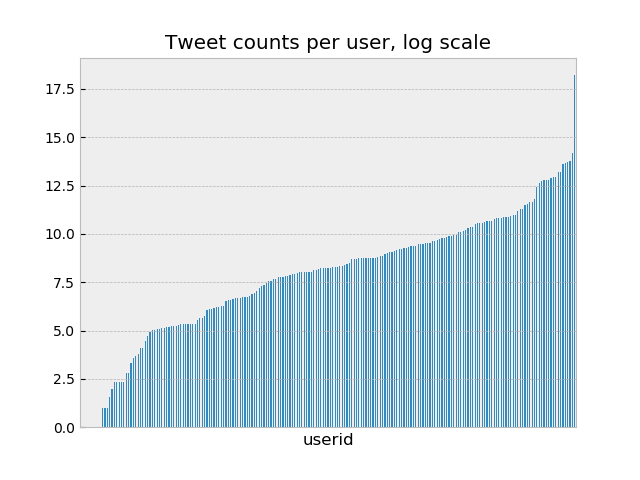

In [20]:
fig, ax = plt.subplots()
ax = np.log2(tweet_counts_per_user
 .sort_values()
).plot(kind='bar', xticks=([]), title=title+', log scale')
fig.show()

In [24]:
title = ('Like counts per user')
print(title)
like_counts_per_user = (campaign
                        .groupby('userid')
                        .sum()
                        .loc[:]['like_count']
                       )
like_counts_per_user.sort_values(ascending=False)

Like counts per user


userid
213589457                                       1799708
DFxoAH9UHHShlGfPqoJOBZroClD8H86DpwySU6YXl4E=     179460
PpOfb+YOWXe3t9rDg7EJ55neK4hKxdNioiA91GAANs=       97741
1099221870530961408                               87908
1091795789263921152                               64480
                                                 ...   
aJdvwfdmprSTKVP0S4dQmEQ3nT5qVnRyYyIdXnYOdyo=          0
djt7FLKLI76zIdPZHvdLNKMth8pEH8+zHauTj5wBc8=           0
BAszjp3oepGsQa6QkPdEbzGMOFLIUxZpwR7JP7NGL8=           0
iBo2Ov46z4inKNY4kNAWbcTtVUSDdEjZkwTBJdpQ5bk=          0
zk4khaX7A3XhXVndteeiXLe4ma8xR7bYMBCOhCt68j8=          0
Name: like_count, Length: 209, dtype: int64

In [25]:
(like_counts_per_user
 .describe()
 .astype('int')
)[['mean','std','min','max']]

mean      13928
std      125374
min           0
max     1799708
Name: like_count, dtype: int64

<IPython.core.display.Javascript object>


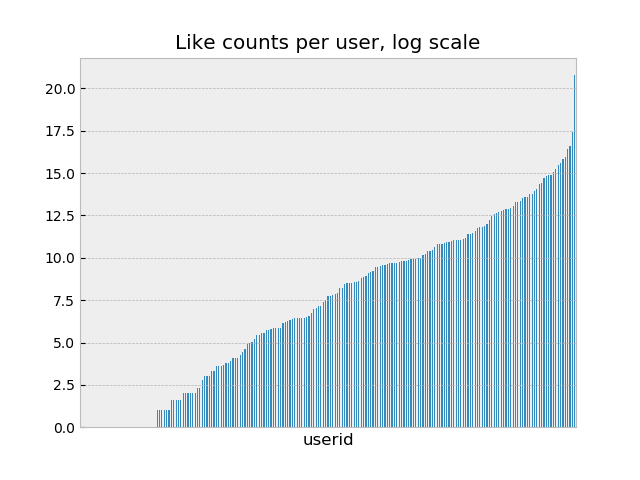

/home/sarah/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
fig, ax = plt.subplots()

ax = np.log2(like_counts_per_user
 .sort_values()
).plot(kind='bar', xticks=([]), title=title+', log scale')

fig.show()

In [27]:
most_liked_tweet = campaign['like_count'].idxmax()
print('"',campaign
 .loc[most_liked_tweet]['tweet_text'],
      '"'
)
print('\nNumber of likes: {}'.format(campaign['like_count'].max()))

" I lived with Kavanaugh at Yale.The FBI never returned my call.

Many were in the same place; they tried to get in contact with FBI, with no luck. Now GOP senators are claiming FBI report showed 'nothing they didn't already know'. Bullshit
https://t.co/aIDK2IZ7ek 

#KavanaughLied "

Number of likes: 63863


In [30]:
(campaign
 .loc[most_liked_tweet][counts]
)

like_count       63863
quote_count       1155
reply_count       1385
retweet_count    26269
Name: 1173315426039869441, dtype: object

In [32]:
most_liked_tweet_user = (campaign
            .loc[most_liked_tweet]['userid']
            )
campaign_users.loc[most_liked_tweet_user][:-4]

user_display_name                DFxoAH9UHHShlGfPqoJOBZroClD8H86DpwySU6YXl4E=
user_screen_name                 DFxoAH9UHHShlGfPqoJOBZroClD8H86DpwySU6YXl4E=
user_reported_location                                             California
user_profile_description    "No one fixes the world alone."\n\n#BlueWave #...
user_profile_url                                                         <NA>
follower_count                                                           2439
following_count                                                          1164
account_creation_date                                     2019-08-18 00:00:00
account_language                                                           en
Name: DFxoAH9UHHShlGfPqoJOBZroClD8H86DpwySU6YXl4E=, dtype: object

In [36]:
(campaign
.groupby('userid')
.get_group(most_liked_tweet_user)
.loc[:]['tweet_text']
)

tweetid
1229755066690809857    Kaitlin Bennett was welcomed by Ohio Universit...
1246761172256382976    I'm not religious &amp; certainly not Christia...
1237383479249252352    Top pro-Warren group endorses Bernie ahead of ...
1238585046371573760    Trump won’t test for #coronavirus despite soci...
1190991490551615488    "after years of horrifying footage of people w...
                                             ...                        
1194220460877197314             @realDonaldTrump https://t.co/m4hxfoFxwt
1261636552461029384    @realDonaldTrump @LisaMarieBoothe @ffweekend “...
1224724777610420224    @realDonaldTrump Your Approval Rating accordin...
1186604356809953281    @realDonaldTrump @kilmeade @foxandfriends Late...
1194608947359031296      @realDonaldTrump WE did https://t.co/2rJXFd4PrI
Name: tweet_text, Length: 1937, dtype: string

Considering this most-liked tweet has an order of magnitude more likes than the next most-liked tweet, we could exclude this outlier in our analyses for a more accurate description of the campaign tweet distributions overall.

## Unique Users

In [37]:
def get_unique_ids(campaign, campaign_users):
    campaign_userids = (campaign_users
           .groupby('userid')
           .size()
           .index
          )
    tweet_userids = (campaign
                   .groupby('userid')
                   .size()
                   .index
                  )
    retweet_userids = (campaign
                   .loc[:]['retweet_userid']
                   .dropna()
                  )
    reply_userids = (campaign
                   .loc[:]['in_reply_to_userid']
                   .dropna()
                  )
    mention_userids = (campaign['user_mentions']
                # expand usernames into columns
                .explode()
                # melt wide table into duplicated tweets
                .reset_index()
                .melt(id_vars=['tweetid'],
                      value_name='mentioned_userid')
                # clean up
                .astype({'mentioned_userid':'string'})
                .drop(columns=['variable'])
                .join(campaign['userid'], on='tweetid')
                .dropna()
               ).loc[:]['mentioned_userid']
    
    return Counter(list(itertools.chain(*[campaign_userids,
                                            tweet_userids,
                                            retweet_userids,
                                            reply_userids,
                                            mention_userids,
                                           ])))

In [38]:
userids = dict(get_unique_ids(campaign, campaign_users))
print('Unique users:', len(userids))

Unique users: 61117


## Interactions

In [41]:
with_outlier = (campaign
               .describe()
              )
without_outlier = (campaign
                .drop(index=most_liked_tweet)
                .describe()
               )

In [48]:
(with_outlier
 .loc[stats][counts]
 .astype('int')
)

,like_count,quote_count,reply_count,retweet_count
mean,5,0,0,5
std,105,3,5,47
min,0,0,0,0
max,63863,1155,2222,26269
mean,5,0,0,5
std,61,2,5,32
min,0,0,0,0
max,18145,1109,2222,9967


In [49]:
(without_outlier
 .loc[stats][counts]
 .astype('int')
)

,like_count,quote_count,reply_count,retweet_count
mean,5,0,0,5
std,61,2,5,32
min,0,0,0,0
max,18145,1109,2222,9967


The standard deviations of count measures are considerably smaller after removing the most-liked tweet:

The plot below gives some indication of the different scales of different types of tweet interactions.

<IPython.core.display.Javascript object>


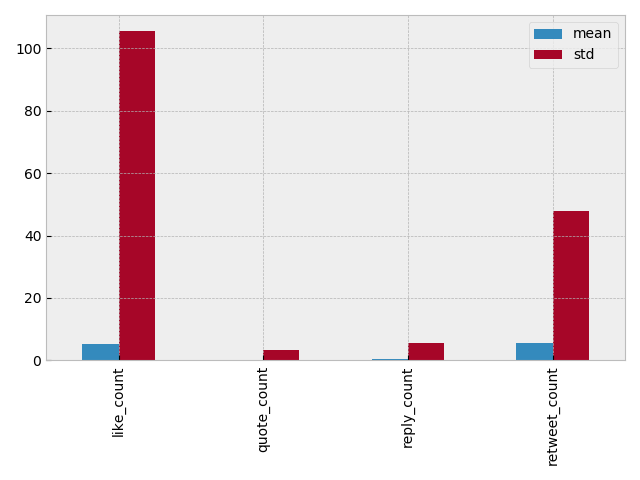

In [55]:
(campaign
 .describe()
 .T
 .loc[counts]
)[plot_stats].plot(kind='bar')
plt.tight_layout()
#ax.set_xlabel=([field.replace('_count', '') for field in fields])

Aggregate counts per user:

In [56]:
(campaign
    .groupby('userid')
    .sum()
    .loc[:][counts]
    .describe()
    .astype('int')
).loc[stats]

,like_count,quote_count,reply_count,retweet_count
mean,13928,644,1125,15008
std,125374,7383,8918,192315
min,0,0,0,0
max,1799708,106618,127521,2780592


#### To do: overall reaction count stats vs per-user count stats

## Original Tweets vs. Retweets

In [57]:
def original_tweets(tweets):
    is_retweet = tweets['is_retweet'] == False
    return (tweets
            .loc[:][is_retweet]
           )

def retweets(tweets):
    is_retweet = tweets['is_retweet'] == True
    return (tweets
            .loc[:][is_retweet]
           )

def replies(tweets):
    is_reply = tweets['in_reply_to_tweetid'].notna()
    return (tweets
            .loc[:][is_reply]
           )

In [77]:
print('Original tweet count: {}'.format(len(original_tweets(campaign))))
print('Retweet count: {}'.format(len(retweets(campaign))))
print('Reply count: {}'.format(len(replies(campaign))))
og_percent = len(original_tweets(campaign)) / len(campaign)
print('Campaign original tweet percent: {:.2%}'.format(og_percent))
rt_percent = len(retweets(campaign)) / len(campaign)
print('Campaign retweet percent: {:.2%}'.format(rt_percent))
re_percent = len(replies(campaign)) / len(campaign)
print('Campaign reply percent: {:.2%}'.format(re_percent))

Original tweet count: 460125
Retweet count: 100446
Reply count: 89139
Campaign original tweet percent: 82.08%
Campaign retweet percent: 17.92%
Campaign reply percent: 15.90%


<IPython.core.display.Javascript object>


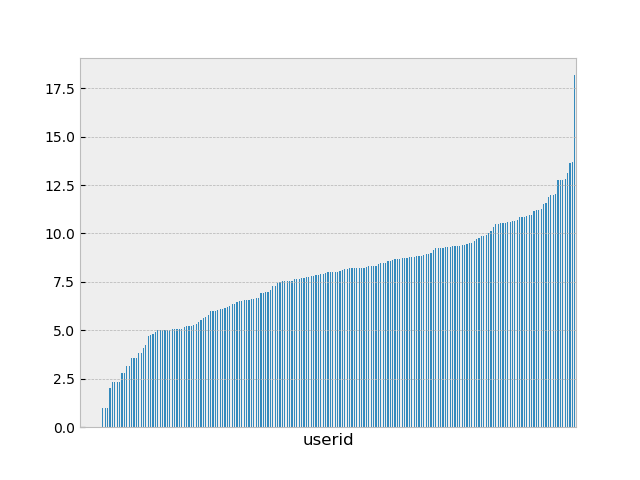

In [73]:
fig, ax = plt.subplots()
ax = np.log2(original_tweets(campaign)
 .groupby('userid')
 .size()
 .sort_values()
).plot(kind='bar',xticks=([]))
fig.show()

<IPython.core.display.Javascript object>


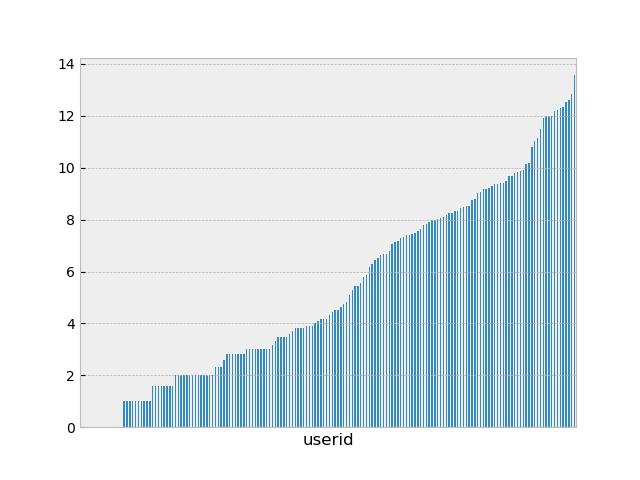

In [74]:
fig, ax = plt.subplots()
ax = np.log2(retweets(campaign)
 .groupby('userid')
 .size()
 .sort_values()
).plot(kind='bar',xticks=([]))
fig.show()

In [106]:
most_tweeting_users = (campaign
                      .groupby('userid')
                      .size()
                      .sort_values(ascending=False)
                      ).head(10)

In [110]:
top_users_rt = (campaign
                .pipe(retweets)
                .groupby('userid')
                .size()
               ).loc[most_tweeting_users.index]
top_users_rt

userid
213589457                                        7336
T8AyWQK3ajadJJL2J+OJovSr4z+rpoK4LqM6ob+wTw=      6241
etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=     5227
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=       17
1067814896706994176                              5960
1235289416370774016                             12143
rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=       5078
WFMM2eW8YAMex3B1z4P8vxx0OvkEJvFCx9l0uYGMqug=     2072
ihPCMQ32xEzpD35Et9IH4HO21XKiWdSJreVg+pHT5o=      3859
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=      4076
dtype: int64

<IPython.core.display.Javascript object>


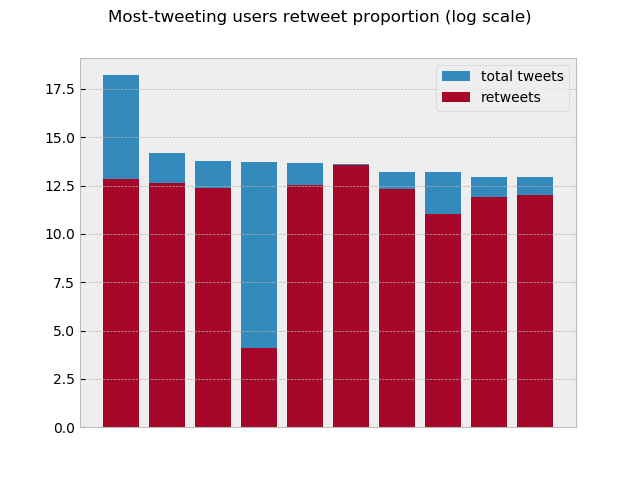

In [115]:
fig, ax = plt.subplots()
ax.bar(most_tweeting_users.index, np.log2(most_tweeting_users), label='total tweets')
ax.bar(most_tweeting_users.index, np.log2(top_users_rt), label='retweets')
ax.set_xticks([])
ax.legend()
fig.suptitle('Most-tweeting users retweet proportion (log scale)')
fig.show()

In [116]:
(original_tweets(campaign)
 .describe()
).loc[stats][counts]

,like_count,quote_count,reply_count,retweet_count
mean,6.33,0.29,0.51,6.82
std,116.32,3.52,6.10,52.80
min,0.00,0.00,0.00,0.00
max,63863.00,1155.00,2222.00,26269.00


In [117]:
(retweets(campaign)
 .describe()
).loc[stats][counts]

,like_count,quote_count,reply_count,retweet_count
mean,0.00,0.00,0.00,0.00
std,0.00,0.00,0.00,0.00
min,0.00,0.00,0.00,0.00
max,0.00,0.00,0.00,0.00


We see here that for this campaign we apparently do not have reaction count data for retweets, indicating that we may need to treat those values as missing when considering reaction statistics for the dataset overall.

## User connections

In [118]:
# retweets between users identified with the campaign
inside_rt = campaign[campaign['retweet_userid']
                     .isin(campaign_users.index)]
(inside_rt
 .groupby(['userid','retweet_userid'])
 .size()
)

userid                                        retweet_userid                              
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=  0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=     25
                                              1099221870530961408                               3
                                              HcrkAj2Z5laESkAd3aQjE1dgoP6r9xDN6LLzEIHzX4=       6
                                              Llwo+0XebgvqnGE1UiwiaJqfQWQF6NJX+gnV77DBRpk=      4
                                              M4AN5Ed68gBwmVS3DcPbwuXv7cJRYDwsCvmJ84BYSB0=      3
                                                                                             ... 
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=   mpY+AZI80Nu61VS3o4Zm+UXTjaxrkE08xU0nO3JQ=        18
                                              rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=       77
                                              tfIRka6bXJoCm84UisMb2m4L8XpKyPJr7Yfv8UmeQ=        2
                           

In [119]:
# replies between users identified with the campaign
inside_re = campaign[campaign['in_reply_to_userid']
                     .isin(campaign_users.index)]
(inside_re
 .groupby(['userid','in_reply_to_userid'])
 .size()
)

userid                                        in_reply_to_userid                          
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=  0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=      19
1067814896706994176                           79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=       2
                                              BYaaZkKxjVQjhsnn9REZ0UcFoEHl+tKnzJ+0Hv+Pg=        11
                                              Bl9IUxp6GStTkiNGbhfBJM9xu85e3Y9BQdNd97GFAI=        1
                                              etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=      77
                                                                                              ... 
xkCWfX+FKOlOHNYjW1jeAG4IfrkxhOZLVbgnDWHVevg=  xkCWfX+FKOlOHNYjW1jeAG4IfrkxhOZLVbgnDWHVevg=      29
y3KkURpZFjT+WeW9e6BcxBYRg311F8fz1eJ647ahQc=   HcrkAj2Z5laESkAd3aQjE1dgoP6r9xDN6LLzEIHzX4=        1
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=   Bl9IUxp6GStTkiNGbhfBJM9xu85e3Y9BQdNd97GFAI=       22
                  

## Misc

In [120]:
(campaign
 .loc[:][campaign['userid'] == max_user]['account_language']
)

tweetid
176529391885619201    es
246981262789709826    es
233634440843243520    es
149698768441327616    es
72108820268195840     es
                      ..
962844249149538304    es
492029494153052161    es
544193600033013760    es
243819549844193280    es
948848104362663936    es
Name: account_language, Length: 302648, dtype: string

In [121]:
(campaign
 .loc[:][campaign['userid'] == max_user]['tweet_language']
 .value_counts()
)

es     185034
und       843
pt        666
ca        275
en        111
ro         79
it         66
sl         44
hu         43
fr         42
in         24
cy         23
tl         21
tr         10
cs          9
ht          9
sk          9
et          9
eu          8
de          5
hi          5
fi          4
lt          3
pl          2
nl          2
bs          2
is          1
no          1
lv          1
sv          1
Name: tweet_language, dtype: Int64

In [122]:
(campaign_users
 .loc[:]['user_reported_location']
 .unique()
)

<StringArray>
[                            <NA>,                      'Worldwide',
              'Brooklyn New York',                           'مشهد',
                          'Paris',                      'Indonesia',
                       'New York',             'Caracas, Venezuela',
                     'NEW JERSEY',                      'Venezuela',
                     'California',                    'Los Angeles',
                          'Earth',                  'IN A DILEMMA ',
         'Minnesota, Minneapolis',                'California, USA',
            'Heidelberg, Germany',                           'iran',
                         'PERSIA',                         'Oregon',
    'The city between two rivers',                 'World Citizen ',
                    'en el mundo', 'زیر باران کنار تنهایی قدم زنان',
                    'California ',                       'Chicago ',
                         'long i',                      'Tampa, FL',
   'Jakarta Selatan,

In [123]:
(campaign
 .loc[:]['account_language']
 .unique()
)

<StringArray>
['fr', 'en', 'fa', 'id', 'en-gb', 'es']
Length: 6, dtype: string

In [124]:
(campaign
 .loc[:]['tweet_language']
 .value_counts()
)

es     193843
en     115723
in      57947
fa      43765
und     15708
ar       7245
fr       6015
pt        792
tl        759
ca        439
et        336
tr        280
th        206
ro        191
hi        179
de        137
it        127
nl        102
ht         94
hu         82
fi         72
eu         69
da         67
ur         58
no         55
cy         49
sl         48
lt         43
ru         41
pl         41
sv         40
cs         36
bn         28
lv         27
id         23
is         18
iw         16
ja         12
ko         11
vi         11
sk          9
zh          8
bs          2
sd          2
uk          1
hr          1
Name: tweet_language, dtype: Int64